In [36]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.metrics import classification_report


In [37]:
data = loadmat('ex3data1.mat')

In [38]:
weights = loadmat('ex4weights.mat')
theta1, theta2 = weights['Theta1'], weights['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [39]:
X = data['X']
y = data['y']

In [40]:
sample_idx = np.random.choice(np.arange(data['X'].shape[0]), 100)
sample_images = data['X'][sample_idx, :]
sample_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

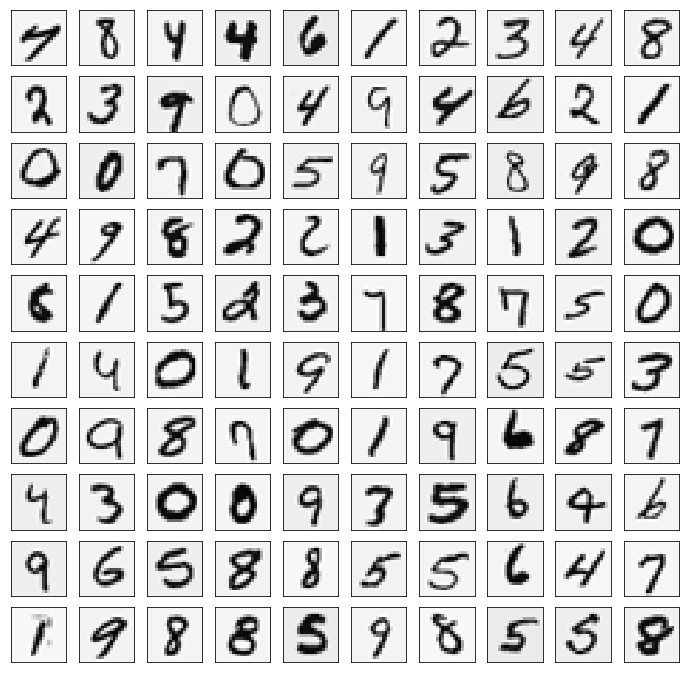

In [41]:
fig, ax_array = plt.subplots(nrows = 10, ncols = 10, sharey = True, sharex = True, figsize = (12, 12))
for r in range(10):
    for c in range(10):
        ax_array[r, c].matshow(np.array(sample_images[10 * r + c].reshape((20,20))).T, cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 
        

In [42]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

In [43]:
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    
    a1 = np.insert(X, 0, np.ones(m), axis = 1)
    z2 = a1 * theta1.T 
    a2 = np.insert(sigmoid(z2), 0, np.ones(m), axis = 1)
    z3 = a2 * theta2.T
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h
    

In [44]:
def cost(theta1, theta2, num_labels, X, y, learning_rate):
    X = np.matrix(X)
    y = np.matrix(y)
    m = X.shape[0]
    
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    J = 0
    for i in range(m):
        J = J + np.sum((np.multiply(-y[i,:], np.log(h[i,:])) - np.multiply(1 - y[i,:], np.log(1 - h[i,:]))))
        
    J = J / m
        
    reg = (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    J += reg
    
    return J

In [45]:
input_size = 400
hidden_size = 25
num_labels = 10
learning_rate = 1
y_class = np.zeros((y.shape[0], num_labels))
for i in range(y.shape[0]):
    y_class[i,int(y[i]) - 1] = 1
    

In [46]:
theta = (np.random.random(size = (input_size + 1) * hidden_size + (hidden_size + 1) * num_labels) - 0.5) * 0.24
theta.shape

(10285,)

In [47]:
def bpnn(theta, input_size, hidden_size, num_labels, X, y, learning_rate):
    X = np.matrix(X)
    y = np.matrix(y)
    m = X.shape[0]
    
    Theta1 = np.matrix(np.reshape(theta[0:(input_size + 1) * hidden_size], (hidden_size, input_size + 1)))
    Theta2 = np.matrix(np.reshape(theta[(input_size + 1) * hidden_size :], (num_labels, hidden_size + 1)))
    
    a1, z2, a2, z3, h = forward_propagate(X, Theta1, Theta2)
    
    delta1 = np.zeros(Theta1.shape)
    delta2 = np.zeros(Theta2.shape)
    
    J = cost(Theta1, Theta2, num_labels, X, y, learning_rate)
    
    for i in range(m):
        d3 = h[i,:] - y[i,:] 
        z2t = np.insert(z2[i,:], 0, np.ones(1))
        d2 = np.multiply(np.dot(Theta2.T, d3.T).T, sigmoid_gradient(z2t))
        
        delta1 = delta1 + d2[:,1:].T * a1[i,:]
        delta2 = delta2 + d3.T * a2[i,:]
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m
    
    
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
        
    return J, grad

In [48]:
from scipy.optimize import minimize

In [49]:
fmin = minimize(fun = bpnn, x0 = theta, args = (input_size, hidden_size, num_labels, X, y_class, learning_rate)
               , method = 'TNC', jac = True, options={'maxiter': 250})
fmin

/Users/kangyifu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Users/kangyifu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


     fun: 0.46422721553675905
     jac: array([-1.09627451e-03, -2.11248326e-12,  4.38829369e-13, ...,
        4.22836352e-04,  3.26160548e-04,  9.61959724e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 15
  status: 3
 success: False
       x: array([ 0.90158136,  0.08031359,  0.11208007, ..., -3.91675743,
       -0.67387262, -1.52415675])

In [50]:
sigmoid_gradient(0)

0.25

In [51]:
thetafinal1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
thetafinal2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

In [52]:
a1, z2, a2, z3, h = forward_propagate(X, thetafinal1, thetafinal2 )
y_pred = np.array(np.argmax(h, axis=1) + 1)
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]])

In [53]:
from sklearn.metrics import classification_report#这个包是评价报告
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.98      0.99      0.99       500
           2       0.99      0.99      0.99       500
           3       0.98      0.97      0.98       500
           4       0.98      0.99      0.99       500
           5       0.99      0.99      0.99       500
           6       0.99      0.99      0.99       500
           7       0.99      0.99      0.99       500
           8       0.99      0.99      0.99       500
           9       0.99      0.97      0.98       500
          10       0.99      1.00      1.00       500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])